# Project 3: Airbnb
**This is the third of three mandatory projects to be handed in as part of the assessment for the course 02807 Computational Tools for Data Science at Technical University of Denmark, autumn 2019.**

#### Practical info
- **The project is to be done in groups of at most 3 students**
- **Each group has to hand in _one_ Jupyter notebook (this notebook) with their solution**
- **The hand-in of the notebook is due 2019-12-05, 23:59 on DTU Inside**

#### Your solution
- **Your solution should be in Python/PySpark**
- **For each question you may use as many cells for your solution as you like**
- **You should not remove the problem statements**
- **Your notebook should be runnable, i.e., clicking [>>] in Jupyter should generate the result that you want to be assessed**
- **You are not expected to use machine learning to solve any of the exercises**

# Introduction
[Airbnb](http://airbnb.com) is an online marketplace for arranging or offering lodgings. In this project you will use Spark to analyze data obtained from the Airbnb website. The purpose of the analysis is to extract information about trends and patterns from the data.

The project has two parts.

### Part 1: Loading, describing and preparing the data
There's quite a lot of data. Make sure that you can load and correctly parse the data, and that you understand what the dataset contains. You should also prepare the data for the analysis in part two. This means cleaning it and staging it so that subsequent queries are fast.

### Par 2: Analysis
In this part your goal is to learn about trends and usage patterns from the data. You should give solutions to the tasks defined in this notebook, and you should use Spark to do the data processing. You may use other libraries like for instance Pandas and matplotlib for visualisation.

## Guidelines
- Processing data should be done using Spark. Once data has been reduced to aggregate form, you may use collect to extract it into Python for visualisation.
- Your solutions will be evaluated by correctness, code quality and interpretability of the output. This means that you have to write clean and efficient Spark code that will generate sensible execution plans, and that the tables and visualisations that you produce are meaningful and easy to read.
- You may add more cells for your solutions, but you should not modify the notebook otherwise.

### Create Spark session and define imports

In [1]:
from pyspark.sql import *
from pyspark.sql import functions as f
from pyspark.sql.types import *
from decimal import *
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName("Project3").getOrCreate()

# Part 1: Loading, describing and preparing the data
The data comes in two files. Start by downloading the files and putting them in your `data/` folder.

- [Listings](https://files.dtu.dk/u/siPzAasj8w2gI_ME/listings.csv?l) (5 GB)
- [Reviews](https://files.dtu.dk/u/k3oaPYp6GjKBeho4/reviews.csv?l) (9.5 GB)

### Load the data
The data has multiline rows (rows that span multiple lines in the file). To correctly parse these you should use the `multiline` option and set the `escape` character to be `"`.

In [2]:
# We start by loading the data with options: 
#   header, inferscheme, escape char =" and multiline. 
#   We load the listings as df and the reviews as dfReviews. 
temp_df = spark.read.option('header',True).option('inferSchema',True).option('escape','"').option('multiLine', 'True').csv('listings.csv')
temp_dfReviews = spark.read.option('header',True).option('inferSchema',True).option('escape','"').option('multiLine', 'True').csv('reviews.csv')

### Describe the data
List the features (schema) and sizes of the datasets.

In [3]:
temp_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- listing_url: string (nullable = true)
 |-- scrape_id: string (nullable = true)
 |-- last_scraped: string (nullable = true)
 |-- name: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- space: string (nullable = true)
 |-- description: string (nullable = true)
 |-- experiences_offered: string (nullable = true)
 |-- neighborhood_overview: string (nullable = true)
 |-- notes: string (nullable = true)
 |-- transit: string (nullable = true)
 |-- access: string (nullable = true)
 |-- interaction: string (nullable = true)
 |-- house_rules: string (nullable = true)
 |-- thumbnail_url: string (nullable = true)
 |-- medium_url: string (nullable = true)
 |-- picture_url: string (nullable = true)
 |-- xl_picture_url: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_url: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- host_since: string (nullable = true)
 |-- host_location: string (nullable

In [4]:
temp_dfReviews.printSchema()

root
 |-- listing_id: string (nullable = true)
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- reviewer_id: string (nullable = true)
 |-- reviewer_name: string (nullable = true)
 |-- comments: string (nullable = true)



In [5]:
# We print the number of rows
temp_df.count()

1330480

In [6]:
temp_dfReviews.count()

23914277

### Prepare the data for analysis
You should prepare two dataframes to be used in the analysis part of the project. You should not be concerned with cleaning the data. There's a lot of it, so it will be sufficient to drop rows that have bad values. You may want to go back and refine this step at a later point when doing the analysis.

You may also want to consider if you can stage your data so that subsequent processing is more efficient (this is not strictly necessary for Spark to run, but you may be able to decrease the time you sit around waiting for Spark to finish things)

In [7]:
# We only select the columns that we need 
df = temp_df.select(f.col('id'),f.col('neighbourhood'),f.col('price'),f.col('city'),f.col('review_scores_rating'))
dfReviews = temp_dfReviews.select(f.col('date'),f.col('listing_id'),f.col('comments'))

In [8]:
# We filter out the data where there is no city and no price, as those will be invalid in our analysis. 
df = df.filter(f.col('city').isNotNull() & f.col('price').isNotNull())

In [9]:
## Define function to convert price to integer data type 
# From looking at the data we notice that the price is in $. Therefore we only remove the dollar sign. 
# We could have cleaned it for any other currency aswell, but then we would also have to convert it according to
#  the current exchange rate. 
def get_price_as_int(price):
    # If it is not in dollars, print error statement
    if("$" not in price):
        print("Error, ", price, " is not in dollars")
    #Remove dollar sign
    priceWihtoutSign = price.replace('$','')
    #remove ","
    priceWihtOutComma = priceWihtoutSign.replace(',','')
    #split on dollars and cents
    pricestring = priceWihtOutComma.split('.')
    price = Decimal(pricestring[0])
    if(len(pricestring)==2):
        price += Decimal(pricestring[1]) / 100
    # We return the price as an interger for simplocity. As most of the prices are quite high, we assume
    #  that removing the cents will not make a huge difference. 
    return int(price)


get_price_as_int_udf = f.udf(get_price_as_int)


In [10]:
# We add a column to the table with the price as integers and thus we make sure that the scheme is also stored 
#. as integers.
df = df.withColumn('priceAsInt', get_price_as_int_udf(f.col('price')))
df = df.withColumn('priceAsInt', f.col('priceAsInt').cast(IntegerType()))

In [11]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- price: string (nullable = true)
 |-- city: string (nullable = true)
 |-- review_scores_rating: string (nullable = true)
 |-- priceAsInt: integer (nullable = true)



# Part 2: Analysis
Use Spark and your favorite tool for data visualization to solve the following tasks.

## The basics
Compute and show a dataframe with the number of listings and neighbourhoods per city.

In [12]:
# We group by city and then count the disctinct number of id's as each listing has a unique ID. 
# We furthermore add a count distinct on the neighbourhood column, 
#.  assuming that there is no errors in the neighbourhood column. 
df.groupBy('city').agg(f.countDistinct('id'),f.countDistinct('neighbourhood')).show()

+--------------------+------------------+-----------------------------+
|                city|count(DISTINCT id)|count(DISTINCT neighbourhood)|
+--------------------+------------------+-----------------------------+
|Saint-Médard-en-J...|               167|                            0|
|Paris-15E-Arrondi...|               100|                            5|
|             Antwerp|               205|                            0|
|            Cadaqués|               463|                            0|
|               Lorne|               315|                            0|
|             Palermo|              9435|                           10|
|             Edogawa|                19|                            1|
|         Agia Galini|                66|                            0|
|        Thessaloniki|              2275|                            0|
|             Lismore|                18|                            0|
|              Tuglie|               106|                       

## Prices
Compute the minimum, maximum and average listing price in your city. 

In [13]:
# We pick Stockholm as our city and filter the city column to only show the cases where it is equal to stockholm. 
stockholm_df =df.filter(f.col('city')=='Stockholm')
# We then use aggregate to find the max, min and avg price on the priceAsInt column. 
stockholm_df.agg(f.min('priceAsInt'),f.max('priceAsInt'),f.avg('priceAsInt')).show()

#The result can bee seen below. 

+---------------+---------------+-----------------+
|min(priceAsInt)|max(priceAsInt)|  avg(priceAsInt)|
+---------------+---------------+-----------------+
|             69|          22463|1103.936496859735|
+---------------+---------------+-----------------+



Compute and visualize the distribution of listing prices in your city.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f40eeedcf60>]],
      dtype=object)

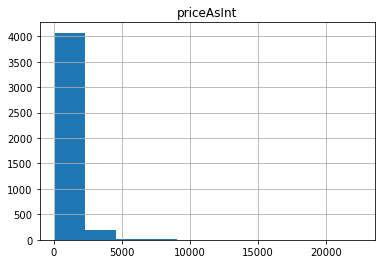

In [14]:
# We use the filter 
#plotdf = df.filter(f.col('city')=='Stockholm')

#We use the stockholm data frame to select all and convert it into a pandas dataframe for plotting purposes. 
pandasdf = stockholm_df.select("*").toPandas()

#We use the boxplot over the column "priceAsInt" to show the distribution of listing prices in Stockholm
pandasdf.hist(column=["priceAsInt"])

The value of a listing is its rating divided by its price.

Compute and show a dataframe with the 3 highest valued listings in each neighbourhood.

In [15]:
# We start by filtering off all the columns that do not have a rating. 
stockholm_df = stockholm_df.filter(f.col('review_scores_rating').isNotNull())

# We then define a column "Value" as described above: Ratingn divided by the price
stockholm_df = stockholm_df.withColumn('Value', f.col('review_scores_rating')/f.col('priceAsInt'))

#We then add a window to partition by neighbourhood and sort by descending value. 
sorted_by_value_window = Window.partitionBy('neighbourhood').orderBy(f.desc('Value'))

# We add a NeighbourhoodValueRank, which is a rank over each listings value
ranked_df = stockholm_df.withColumn('NeighbourhoodValueRank', f.rank().over(sorted_by_value_window))

# We then filter so we only show the top three of every neighbourhood. And orderby neighbourhood in descending order
ranked_df.filter(f.col('NeighbourhoodValueRank') <= 3).select('city','neighbourhood','id','NeighbourhoodValueRank','review_scores_rating','priceAsInt').orderBy('neighbourhood', f.desc('Value')).show(1000, False)

+---------+---------------------+--------+----------------------+--------------------+----------+
|city     |neighbourhood        |id      |NeighbourhoodValueRank|review_scores_rating|priceAsInt|
+---------+---------------------+--------+----------------------+--------------------+----------+
|Stockholm|null                 |23573868|1                     |100                 |69        |
|Stockholm|null                 |19950599|2                     |98                  |94        |
|Stockholm|Bromma               |24191331|1                     |93                  |117       |
|Stockholm|Bromma               |15260947|2                     |100                 |225       |
|Stockholm|Bromma               |13098304|3                     |99                  |264       |
|Stockholm|Enskede-Årsta-Vantör |31549534|1                     |100                 |147       |
|Stockholm|Enskede-Årsta-Vantör |29206032|2                     |100                 |196       |
|Stockholm|Enskede-Å

## Trends
Now we want to analyze the "popularity" of your city. The data does not contain the number of bookings per listing, but we have a large number of reviews, and we will assume that this is a good indicator of activity on listings.

Compute and visualize the popularity (i.e., number of reviews) of your city over time.

In [16]:
# We take only the id, city and the neighbourhood from the original listings dataframe
city_id_df = df.select(f.col('id'),f.col('city'), f.col('neighbourhood'))
# We rename listings_id to id, so that it matches the id column of the reviews dataframe. 
city_id_df = city_id_df.withColumnRenamed('id', 'listing_id')

# The two data frames are then joined on the column id. That way we get a new dataframe with the columns from the 
# Reviews dataframe with city and neighbourhoods in it. 
rwc_df = dfReviews.join(city_id_df, on=['listing_id'] )

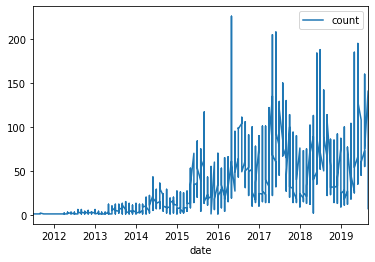

In [17]:
# We then filter by our city Stockholm
reviews_stockholm_df = rwc_df.filter(f.col('city')=='Stockholm')

#For the plot of number of reviews over time we first group by date
# Then we count the number of reviews for those dates and sort them. 
plot_reviews_df = reviews_stockholm_df.groupBy(f.col('date')).count().sort('date')

# We truncate all dates to the first of each month, to get a graph that is more readable.
plot_review_by_month_df = plot_reviews_df.withColumn("date", f.trunc("date", "month"))

#Conversion into Pandas Dataframe for plotting purposes.
pandasdfReviews = plot_review_by_month_df.toPandas()

#We plot the number of reviews over time. 
pandasdfReviews.plot(x='date', y='count')

Compute and visualize the popularity of neighbourhoods over time. If there are many neighbourhoods in your city, you should select a few interesting ones for comparison.

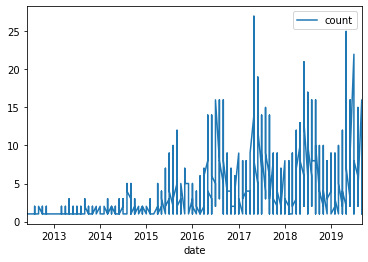

In [18]:
# We pick three interesting neighbourhoods of Stockholm; 
# Östermalm, Norrmalm and Kungsholm. These are defined by filtering on the chosen neighbourhoods. 
ostermalm_df = reviews_stockholm_df.filter(f.col('neighbourhood') =='Östermalm')
norrmalm_df = reviews_stockholm_df.filter(f.col('neighbourhood') =='Norrmalm')
kungsholmen_df = reviews_stockholm_df.filter(f.col('neighbourhood') =='Kungsholmen')

#The following code is the same for the three neighbourhood, therefore it is only commented here. 

#We start by group by date and count them and sort these. 
plot_ostermalm_df = ostermalm_df.groupBy(f.col('date')).count().sort('date')
# We truncate all dates to the first of each month, to get a graph that is more readable.
plot_ostermalm_by_month_df = plot_ostermalm_df.withColumn("date", f.trunc("date", "month"))

#Conversion into Pandas Dataframe for plotting purposes.
pdOstermalm = plot_ostermalm_by_month_df.toPandas()

#We plot the number of reviews over time. 
pdOstermalm.plot(x='date', y='count')

In [ ]:
plot_norrmalm_df = norrmalm_df.groupBy(f.col('date')).count().sort('date')
plot_norrmalm_by_month_df = plot_norrmalm_df.withColumn("date", f.trunc("date", "month"))
pdNorrmalm = plot_norrmalm_by_month_df.toPandas()

pdNorrmalm.plot(x='date', y='count')

In [ ]:
plot_kungsholmen_df = kungsholmen_df.groupBy(f.col('date')).count().sort('date')
plot_kungsholmen_by_month_df = plot_kungsholmen_df.withColumn("date", f.trunc("date", "month"))
pdkungsholmen = plot_kungsholmen_by_month_df.toPandas()

pdkungsholmen.plot(x='date', y='count')

Compute and visualize the popularity of your city by season. For example, visualize the popularity of your city per month.

In [ ]:
# To plot the popularity we group by the month of the date column. That is, we take a date and the only extract the month
# We then have all reviews only by thier month. The year and the date is gone. 
# We then count and sort them,
# convert them into a pandas dataframe and plot them in the number of reviews pr month. 

plot_review_by_month_df.groupBy(f.month('date').alias('month')).count().sort(f.col('month')).toPandas().plot(x='month', y='count')

## Reviews
In this part you should determine which words used in reviews that are the most positive. 

The individual reviews do not have a rating of the listing, so we will assume that each review gave the average rating to the listing, i.e., the one on the listing.

You should assign a positivity weight to each word seen in reviews and list the words with the highest weight. It is up to you to decide what the weight should be. For example, it can be a function of the rating on the listing on which it occurs, the number of reviews it occurs in, and the number of unique listings for which it was used to review.

Depending on your choice of weight function, you may also want to do some filtering of words. For example, remove words that only occur in a few reviews.

In [ ]:
def text_to_words(text):
    # Make all chars lowercase
    lowercase = text.lower()
    #Build translation table - From punctiuation map to nothing
    table = str.maketrans("","",string.punctuation)
    # translate string by translation table
    noPunct = lowercase.translate(table)
    # Split the string into a list with no delimiter
    result = noPunct.split()
    return result


avg_id_df = df.select(f.col('id'),f.col('review_scores_rating'))
avg_id_df = avg_id_df.withColumnRenamed('id', 'listing_id')
avg_reviews_df = dfReviews.join(avg_id_df, on=['listing_id'])
avg_reviews_df.select(f.col('comments'), f.col('review_scores_rating'))#.show()
#avg_reviews_df.show()
avg_reviews_df = avg_reviews_df.select(f.explode(f.split('comments', " ")),'review_scores_rating').withColumnRenamed('col', 'word')
avg_reviews_df = avg_reviews_df.groupBy('word').agg(f.count('review_scores_rating'),f.sum('review_scores_rating'))
avg_reviews_df = avg_reviews_df.withColumn('value', f.col('sum(review_scores_rating)')/f.col('count(review_scores_rating)'))
avg_reviews_df = avg_reviews_df.filter(f.col('count(review_scores_rating)') > 50)
#avg_reviews_df = avg_reviews_df.filter(f.col('word')) =>)  #x => x.length>0
avg_reviews_df = avg_reviews_df.orderBy(f.desc('value'))
#stockholm_df = stockholm_df.withColumn('Value', f.col('review_scores_rating')/f.col('priceAsInt'))

#stockholm_df =df.filter(f.col('city')=='Stockholm')

avg_reviews_df.select('word','value').show()
#df.groupBy('city').agg(f.countDistinct('id')

In [ ]:
rating = 98
word = "hello, my name is"
rating2 = 2
word1 = "Hello"
rating3 = 22

#register_comment_rating(word,rating)
#register_comment_rating(word,rating2)
#register_comment_rating(word1,rating2)
#register_comment_rating(word1,rating3)

register_word_rating_udf = f.udf(register_comment_rating)

print(word_dict)

In [ ]:
#avg_reviews_df.foreach(register_comment_rating('comment',1))
#.explain()
#register_word_rating_udf(f.col('comments'),f.col('review_scores_rating'))

In [ ]:
print(word_dict)

In [ ]:
avg_reviews_df.foreach